# 1. Unknown source weights
## a) Problem definition

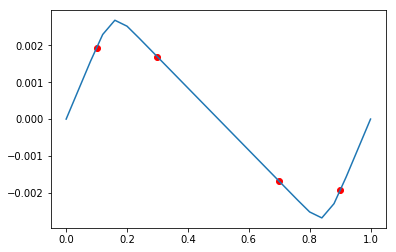

In [1]:
import fenics as fe
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import fenics as fe


def make_source_term(sources):
    code = "w*exp(-pow(x[0] - p, 2)/0.001)"
    f = fe.Constant(0)
    for (weight, position) in sources:
        f += fe.Expression(code, degree=1, p=position, w=weight)
    return f

def solve_heat_eq(sources):
    level = 25
    mesh = fe.UnitIntervalMesh.create(level)

    V = fe.FunctionSpace(mesh, 'P', 1)

    def boundary(x, on_boundary):
        return on_boundary

    bc = fe.DirichletBC(V, fe.Constant(0), boundary)

    u = fe.TrialFunction(V)
    v = fe.TestFunction(V)

    f = make_source_term(sources)

    a = fe.dot(fe.grad(u), fe.grad(v)) * fe.dx
    L = f * v * fe.dx

    u = fe.Function(V)
    fe.solve(a == L, u, bc)

    return u

positions = np.array([0.15, 0.85])
real_weights = np.array([0.5, -0.5])
sources = zip(real_weights, positions)

measurement_points = np.array([0.1, 0.3, 0.7, 0.9])

u = solve_heat_eq(sources)
data = np.array([u(x) for x in measurement_points]) # + 0.001*np.random.normal(size=len(measurement_points))

fe.plot(u)
plt.scatter(measurement_points, data, c="red")

## b) EnKF solution

In [2]:
def mean_kro(x, y):
    C = np.zeros((x.shape[1], y.shape[1]))
    for i in range(x.shape[0]):
        C += x[i:i+1,:].T.dot(y[i:i+1,:])
    return C/x.shape[0]

def G(u):
    res = np.zeros((u.shape[0],data_dims))
    for i in range(u.shape[0]):
        u_ = solve_heat_eq(zip(u[i,:], positions))
        res[i,:] = [u_(x) for x in measurement_points]
    return res

particles = 5
state_dims = 2
data_dims = len(measurement_points)

u_real = real_weights.reshape((1,state_dims))
y = G(u_real).reshape(data_dims)

u = np.random.normal(size=particles*state_dims).reshape((particles,state_dims))

n_steps = 20
h = 1.0 / n_steps

u_hats = np.zeros((n_steps, state_dims))

for j in range(n_steps):
    p = G(u)
    
    p_bar = np.average(p, axis=0).reshape((1,data_dims))
    u_bar = np.average(u, axis=0).reshape((1,state_dims))
        
    C_up = mean_kro(u - u_bar, p - p_bar)
    C_pp = mean_kro(p - p_bar, p - p_bar)
    
    for i in range(particles):
        u[i,:] += C_up.dot(np.linalg.solve(C_pp + 1e-10*np.eye(data_dims), y - p[i,:])).reshape(state_dims)
    
    u_hat = u.mean(axis=0)
    y_hat = G(u_hat.reshape((1,state_dims)))

    # mean e
    print(np.mean(np.linalg.norm(u - u_hat, 2, axis=1)))
    
    
print('\nRes['+str(n_steps)+']:')
u_hat = u.mean(axis=0)
y_hat = G(u_hat.reshape((1,state_dims)))

print('Ensemble')
print(u)

print('\nEnsemble mean')
print(u_hat)

print('\nReal')
print(real_weights)

print('\nProjected mean')
print(y_hat)

print('\nData')
print(y)

8.422812175192685e-06
8.422581112260159e-06
8.4223500687238e-06
8.422119044598559e-06
8.421888039836876e-06
8.42165705448642e-06
8.421426088511677e-06
8.421195141927178e-06
8.420964214727585e-06
8.420733306886394e-06
8.420502418442096e-06
8.420271549369232e-06
8.4200406996759e-06
8.419809869325357e-06
8.419579058343027e-06
8.419348266726254e-06
8.419117494454467e-06
8.41888674154285e-06
8.418656007980633e-06
8.41842529378579e-06

Res[20]:
Ensemble
[[ 0.499983   -0.49998124]
 [ 0.49999338 -0.49999142]
 [ 0.4999737  -0.49996839]
 [ 0.49998075 -0.49997683]
 [ 0.49998728 -0.49998562]]

Ensemble mean
[ 0.49998362 -0.4999807 ]

Real
[ 0.5 -0.5]

Projected mean
[[ 0.00192926  0.00168514 -0.00168511 -0.00192924]]

Data
[ 0.00192932  0.00168519 -0.00168519 -0.00192932]


# 2. Linear system of equations
## a) Problem definition

In [141]:
def rot(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array(((c,-s), (s, c)))

A = rot(np.pi/3)

def G(u):
    res = np.zeros((u.shape[0],data_dims))
    for i in range(u.shape[0]):
        res[i,:] = A.dot(u[i,:])
    return res

particles = 5
state_dims = 2
data_dims = 2

u_real = np.array([[1, 1]])
y = G(u_real).reshape(data_dims) + np.random.normal(loc=0, scale=0.01, size=2)

## b) Continuous time limit

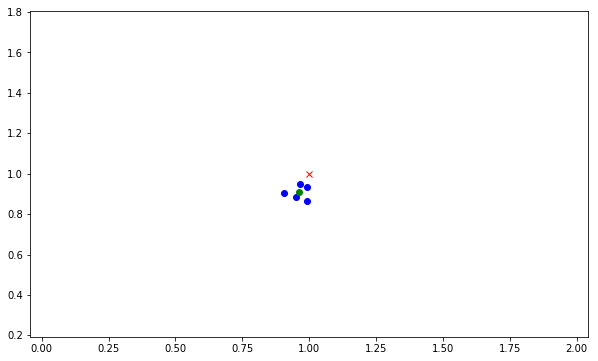

In [142]:
from matplotlib import animation
from IPython.display import HTML
from scipy.integrate import ode

def rhs(t, u):
    u = u.reshape((particles,state_dims))
    du = np.zeros_like(u)
    
    p = G(u)
    
    p_bar = np.average(p, axis=0).reshape((1,data_dims))
    u_bar = np.average(u, axis=0).reshape((1,state_dims))
        
    C_up = mean_kro(u - u_bar, p - p_bar)
    
    for j in range(u.shape[0]):
        du[j,:] = C_up.dot(y - p[j,:]).reshape(state_dims)
    
    return du.reshape(particles*state_dims)

t1=500
dt=5

u=np.random.normal(size=particles*state_dims).reshape((particles,state_dims))
r=ode(rhs).set_integrator('dopri5')
r.set_initial_value(u.reshape(particles*state_dims), 0)

fig, ax = plt.subplots(figsize=(10, 6))
w = np.max(u[:,0]) - np.min(u[:,0])
h = np.max(u[:,1]) - np.min(u[:,1])

path = np.zeros((int(t1/dt), u.shape[0], u.shape[1]))

def init():
    plt_particles.set_data([], [])
    plt_truth.set_data(u_real[:,0], u_real[:,1])
    plt_mean.set_data([], [])
    
    return plt_particles, plt_truth, plt_mean

def animate(i):
    r.integrate(r.t+dt)
    u = r.y.reshape((particles,state_dims))
    path[i,:,:] = u
    
    u_bar = u.mean(axis=0).reshape((1,state_dims))
    
    plt_particles.set_data(u[:, 0], u[:, 1])
    plt_mean.set_data(u_bar[:, 0], u_bar[:, 1])
    
    ax.set_xlim((u_real[0,0]-w/2, u_real[0,0]+w/2))
    ax.set_ylim((u_real[0,1]-h/2, u_real[0,1]+h/2))

    return plt_particles,plt_truth,plt_mean

plt_particles, = ax.plot([], [], 'bo', ms=6)
plt_truth, = ax.plot([], [], 'rx', ms=6)
plt_mean, = ax.plot([], [], 'go', ms=6)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(t1/dt), interval=60, 
                               repeat_delay=5, blit=True)
HTML(anim.to_html5_video())

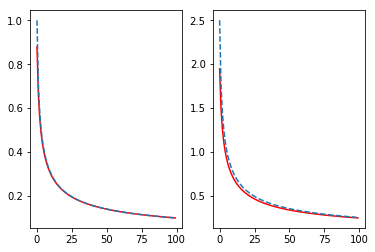

In [143]:

u_bars = path.mean(axis=1)
e = np.zeros(path.shape[0])
r = np.zeros(path.shape[0])

for i in range(path.shape[0]):
    e[i] = np.linalg.norm(path[i,:,:] - u_bars[i])
    r[i] = np.linalg.norm(path[i,:,:] - u_real[0,:])

    
plt.subplot(121)
plt.plot(e, c='r')
plt.plot(1/np.array(range(1,100))**0.5, '--')

plt.subplot(122)
plt.plot(r, c='r')
plt.plot(2.5/np.array(range(1,100))**0.5, '--')
